<a href="https://www.kaggle.com/code/ramezmaged/check-optical-character-recognition?scriptVersionId=168920700" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install pytesseract

In [3]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract

Reading package lists... Done

Building dependency tree... Done

Reading state information... Done

The following additional packages will be installed:

  tesseract-ocr-eng tesseract-ocr-osd

The following NEW packages will be installed:

  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd

0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.

Need to get 4,816 kB of archives.

After this operation, 15.6 MB of additional disk space will be used.

Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]

Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]

Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]

Fetched 4,816 kB in 1s (9,182 kB/s)

Selecting previously unselected package tesseract-ocr-eng.

(Reading database ... 121753 files and directories currently installed.)

Preparing to unpack ..

In [4]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from PIL import Image
import pytesseract
from pytesseract import Output
import re

In [1775]:
file_name = '/content/1091-receipt.jpg'

In [1776]:
img= Image.open(file_name)

In [1777]:
img.thumbnail((800,800), Image.ANTIALIAS)


<ipython-input-1777-81e68a0f1632>:1: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.

  img.thumbnail((800,800), Image.ANTIALIAS)


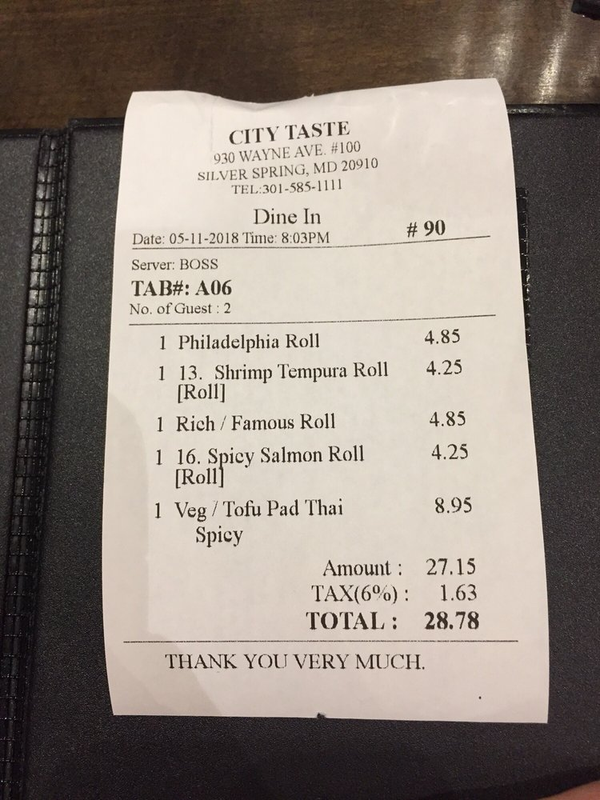

In [1778]:
img

In [1779]:
image = cv2.imread(file_name)
image.shape

(1000, 750, 3)

In [1780]:
def opencv_resize(image,ratio):
  height = int(image.shape[0] * ratio)
  width = int(image.shape[1] * ratio)
  dim = (width, height)
  return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [1781]:
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

In [1782]:
image.shape

(500, 375, 3)

In [1783]:
def plot_gray(image):
  plt.figure(figsize = (16,10))
  return plt.imshow(image, cmap = 'Greys_r')

In [1784]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray.shape

(500, 375)

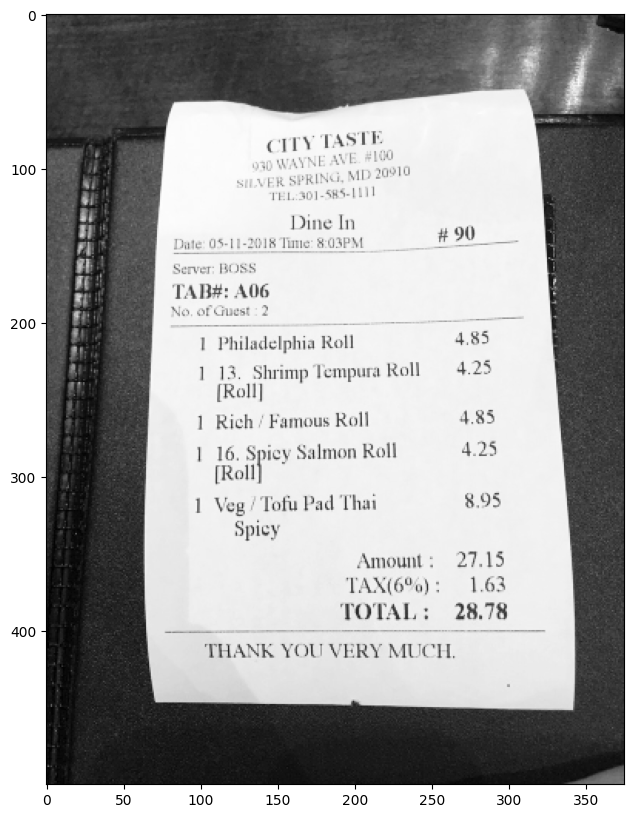

In [1785]:
plot_gray(gray)

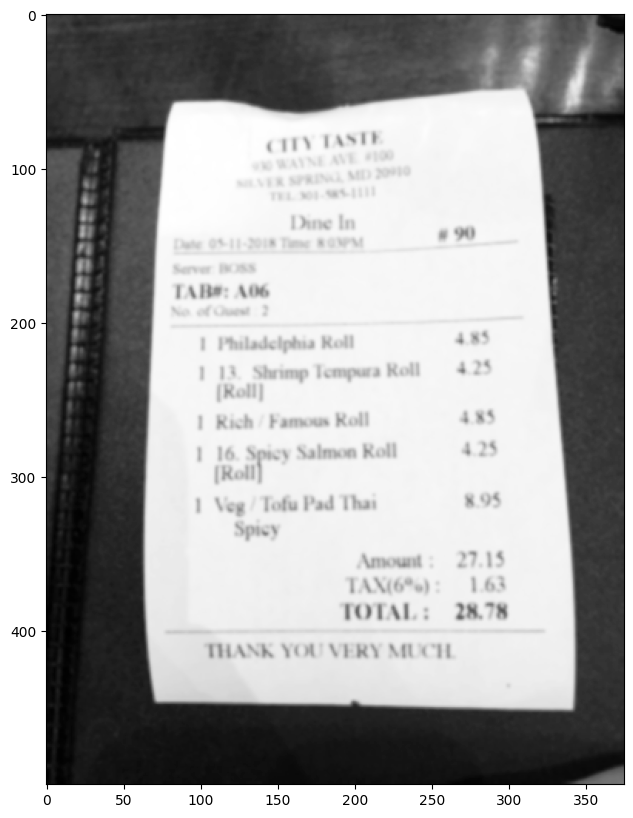

In [1786]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

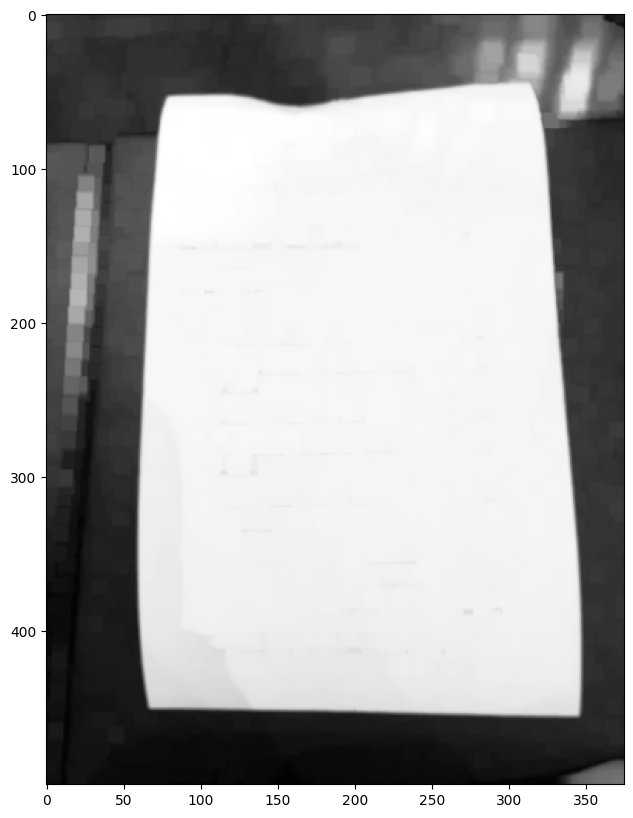

In [1787]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

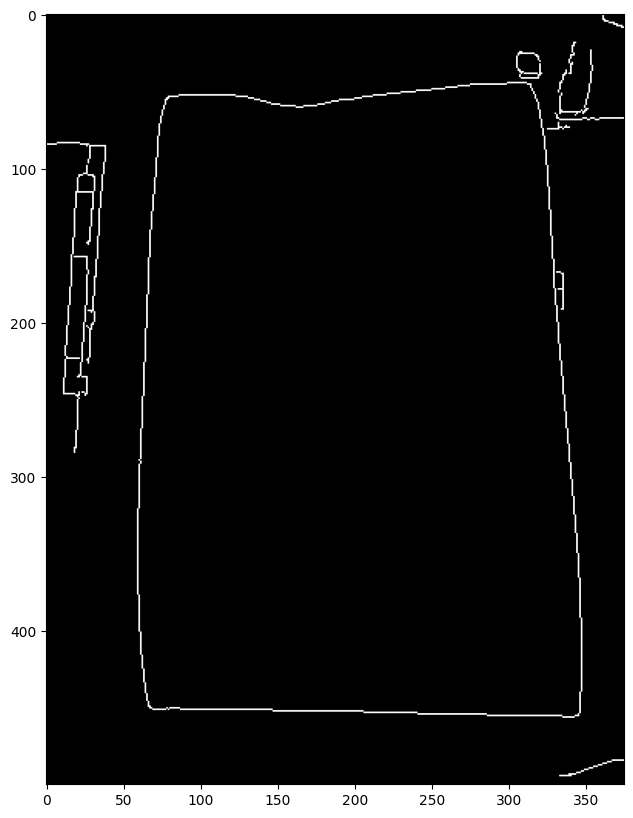

In [1788]:
edged = cv2.Canny(dilated, 50, 150, apertureSize = 3)
plot_gray(edged)

In [1789]:

def plot_rgb(image):

  plt.figure(figsize=(16,10))
  return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

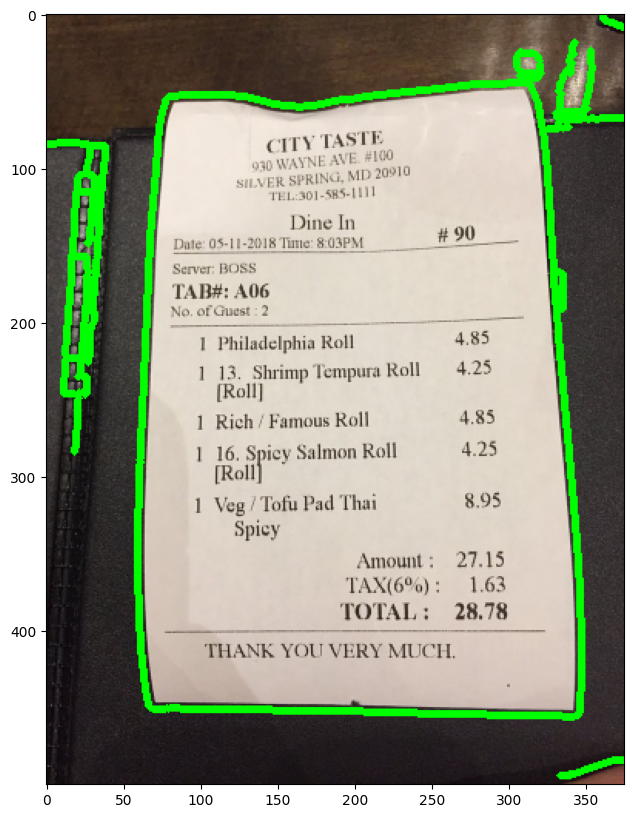

In [1790]:
# Detect all contours in Canny-edged image

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt :

receipt is the largest contour whithin image


receipt is expected to be of a rectangular shape




We will start with TOP largest contours.



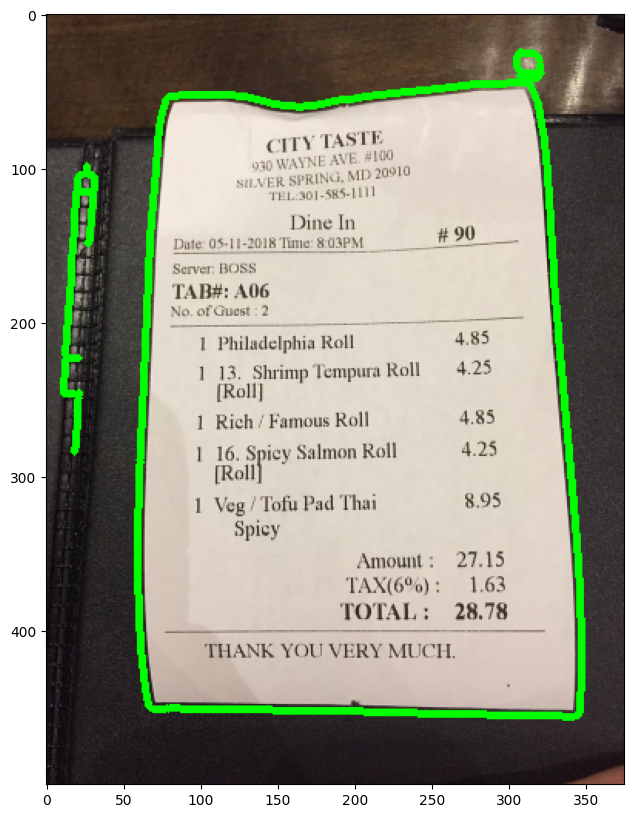

In [1791]:
# Get largest contours

largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:3]
if cv2.contourArea(largest_contours[0]) < 50000:

  # If the largest contour is smaller, draw a contour on the entire image
  image_height, image_width = image.shape[:2]
  entire_contour = np.array([[0, 0], [0, image_height], [image_width, image_height], [image_width, 0]], dtype=np.int32)
  largest_contours[0] = entire_contour


image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [1792]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [1793]:
approximate_contour(largest_contours[0])

array([[[314,  45]],

       [[ 77,  55]],

       [[ 67, 450]],

       [[345, 455]]], dtype=int32)

In [1794]:
def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        else:
          points = approximate_contour(largest_contours[0])

          # Reshape the array for convenience
          points = points.reshape(-1, 2)

          # Sort the points based on their x-coordinates
          sorted_points = points[np.argsort(points[:, 0]), :]

          # The top-left point will have the smallest sum, bottom-right will have the largest sum
          tl = sorted_points[np.argmin(sorted_points.sum(axis=1))]
          br = sorted_points[np.argmax(sorted_points.sum(axis=1))]

          # The top-right point will have the smallest difference, bottom-left will have the largest difference
          tr = sorted_points[np.argmin(np.diff(sorted_points, axis=1))]
          bl = sorted_points[np.argmax(np.diff(sorted_points, axis=1))]

          # Now you have the four corners of the rectangle
          rectangle = np.array([tl, tr, br, bl], dtype="float32")
          return rectangle


In [1795]:
get_receipt_contour(largest_contours)


array([[[314,  45]],

       [[ 77,  55]],

       [[ 67, 450]],

       [[345, 455]]], dtype=int32)

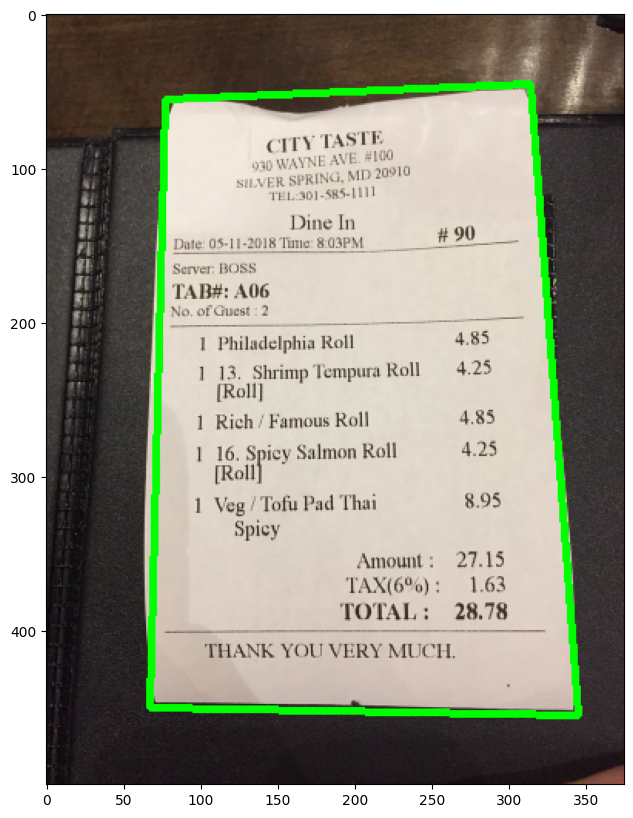

In [1796]:
receipt_contour = get_receipt_contour(largest_contours)
if receipt_contour is not None and len(receipt_contour) > 0:
    image_with_receipt_contour = image.copy()
    cv2.drawContours(image_with_receipt_contour, [receipt_contour.astype(int)], -1, (0, 255, 0), 3)
    plot_rgb(image_with_receipt_contour)

else:
    print("No valid receipt contour found.")

In [1797]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [1798]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

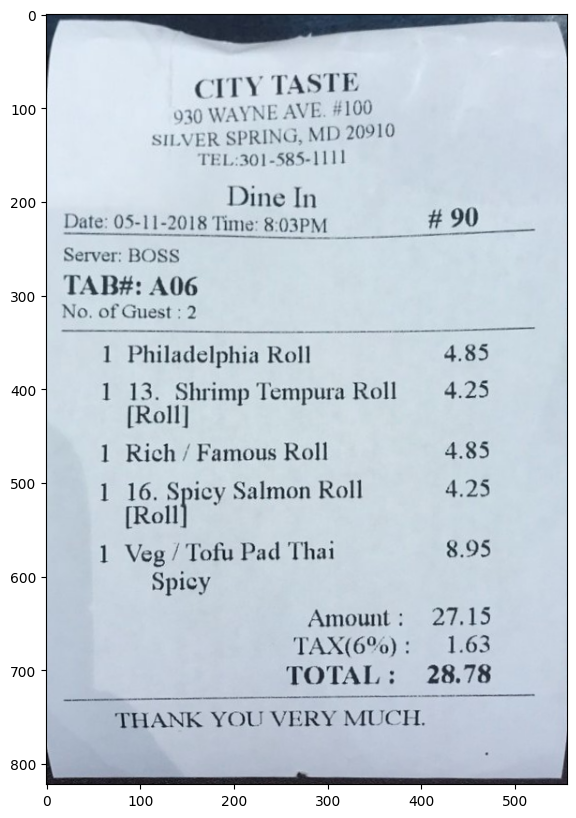

In [1799]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [1800]:
def bw_scanner(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  T = threshold_local(gray, 21, offset = 5, method = 'gaussian')
  return (gray > T).astype("uint8") * 255

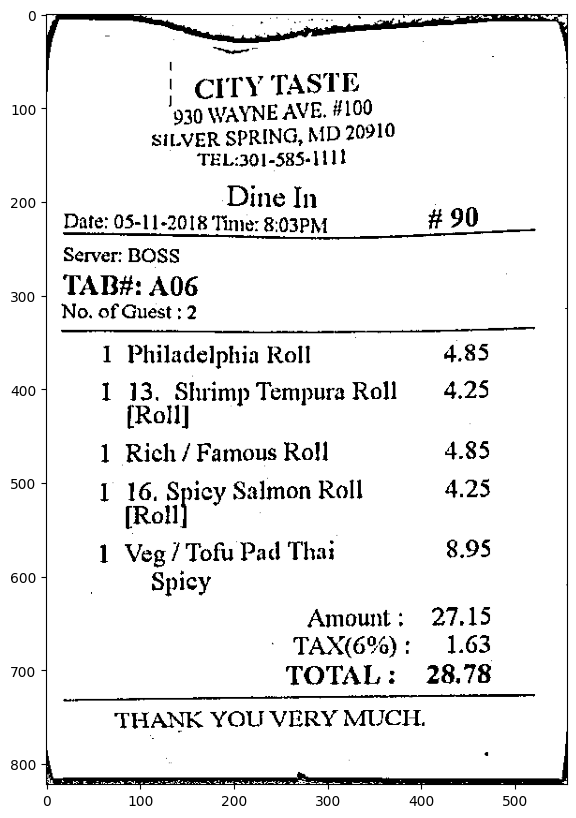

In [1801]:
result = bw_scanner(scanned)
plot_gray(result)

In [1802]:
output = Image.fromarray(result)


In [1803]:
output.save('result.png')

In [1804]:
file_name = '/content/result.png'

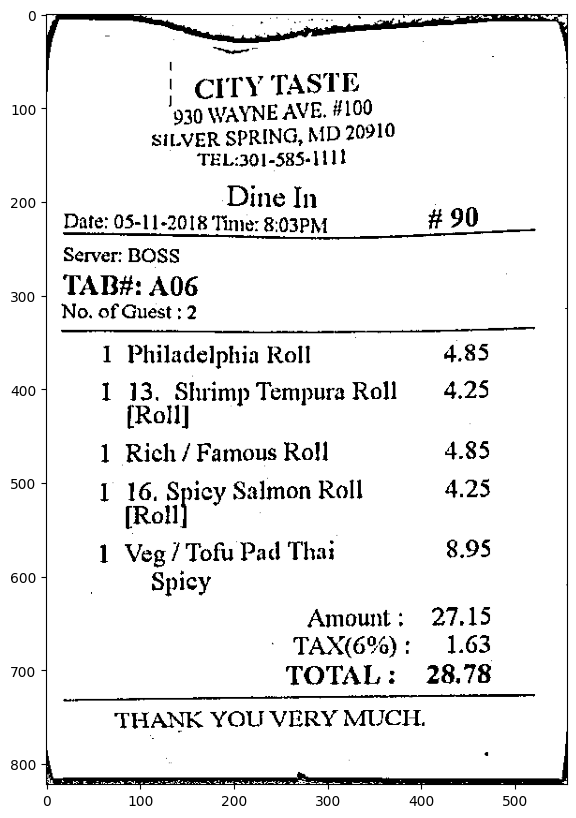

In [1805]:
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)

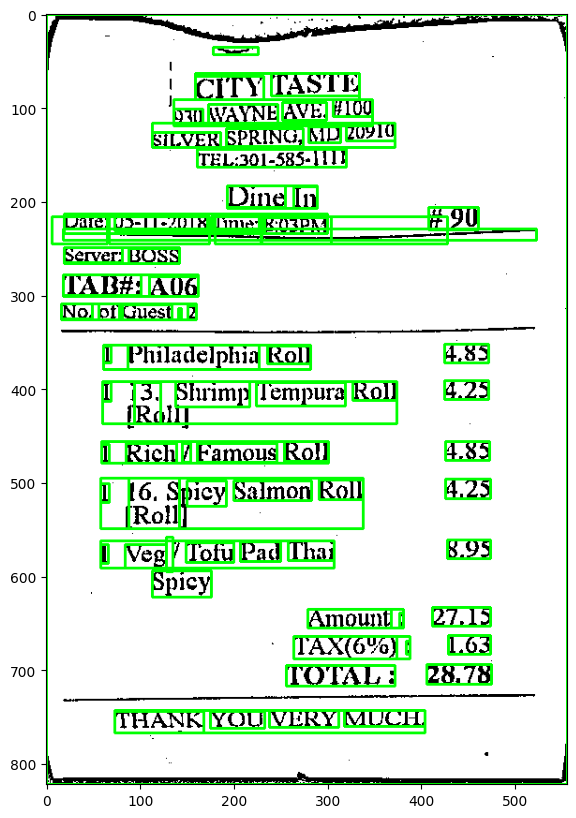

In [1806]:
d = pytesseract.image_to_data(image.copy(), output_type = Output.DICT,config = r'--psm 11')
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
  (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
  boxes = cv2.rectangle(boxes, (x,y), (x + w, y + h), (0,255,0), 2)

plot_rgb(boxes)


In [1807]:
extracted_text = pytesseract.image_to_string(image.copy(),config = r'--psm 11')
print(extracted_text)

~~



CITY TASTE



930 WAYNE AVE. #100



SILVER SPRING, MD 20910



TEL:301-585-1111



Dine In



aoe Boies time: 8:03PM OE



Date: 05-11-2018 Time: 8:03PM



#90



Server: BOSS



TAB#: A06



No. of Guest ; 2



4.85



1 Philadelphia Roll



4.25



1 3. Shrimp Tempura Roll



1 Rich / Famous Roll



4.85



4.25



I 16.8 picy Salmon Roll



1 Veg / Tofu Pad Thai



8.95



Spicy



Amount ;



27.15



TAX(6%) :



1.63



TOTAL:



28.78



THANK YOU VERY MUCH.




In [1808]:
def find_amounts(text):
  amounts = re.findall(r'\d+\s?[\.,°]\s?\d{2}\b', text)
  floats = [float(amount.replace('°', '.').replace(' ', '').replace('° ','.').replace('..','.').replace(',','.')) for amount in amounts]
  unique = list(dict.fromkeys(floats))

  return floats

In [1809]:
amounts = find_amounts(extracted_text)
amounts

[4.85, 4.25, 4.85, 4.25, 8.95, 27.15, 1.63, 28.78]

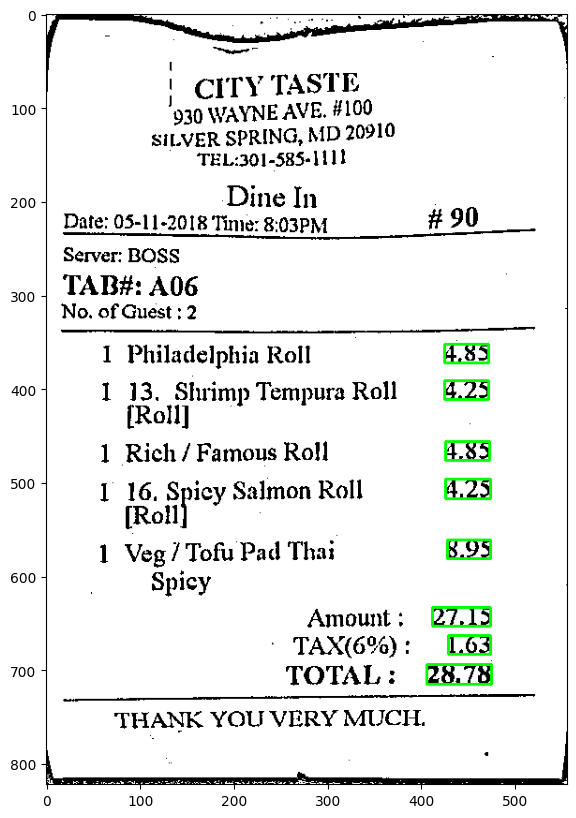

In [1810]:
data = pytesseract.image_to_data(image, output_type=Output.DICT,config = r'--psm 11')
n_boxes = len(data['text'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# Get the width of the image to determine the right half
image_width = image.shape[1]

for i in range(n_boxes):
    text = data['text'][i]
    # Check if the text element is a float with exactly two decimal places #r'\d+[\.,]\d{2}\b$'
    if re.match(r'(?:-?[\$§-“])?\d+\s?[.,°]\s?\d{2}(?:[\$§])?\b', text):
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        # Check if the bounding box is in the right half of the image
        if x >= image_width / 2:

          boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Plot the image with contours drawn only on the right half
plot_rgb(boxes)